In [1]:
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.externals import joblib

import hdbscan

import pickle

import PreprocessText

In [ ]:
df = pd.read_pickle('data/EPMC/eye_in_new_keywords.pkl')
df.set_index('pmid',inplace=True)
df = df[~df.index.isnull()]
kw_pubYear = df['firstPublicationDate']
kw_pubYear = pd.to_datetime(kw_pubYear)
kw_pubYear = kw_pubYear.dt.year
del df

kw_abstracts = pd.read_pickle('data/EPMC/eye_in_new_keywords_ABSTRACTS_LEMMA.pkl')
kw_pmids = kw_abstracts.index

countvec = joblib.load('models/sklearn/CountVec.joblib')
features = countvec.get_feature_names()

countvec_vectors = pd.read_pickle('data/EPMC/eye_in_new_keywords_ABSTRACTS_COUNTVEC.pkl')

lda = joblib.load('models/sklearn/LDA_50topics_alleyekw.joblib') 
topics = pd.DataFrame(lda.components_,columns=features)

#lda_kw = pd.read_pickle('data/EPMC/eye_in_new_keywords_ABSTRACTS_LDAVEC.pkl')
lda_kw = lda.transform(countvec_vectors)

lda_kw = pd.DataFrame(lda_kw,index=kw_pmids)

In [ ]:
'''
kw_pubYear = kw_pubYear[kw_pubYear.index.isin(kw_pmids)]
kw_pmids = kw_pmids[kw_pmids.isin(kw_pubYear.index)]
lda_kw = lda_kw.loc[kw_pmids]

kw_abstracts = kw_abstracts[kw_abstracts.index.isin(kw_pmids)]
'''

In [ ]:
ffs = pd.read_pickle('data/EPMC/ffs_or_predecessors.pkl')
ffs.set_index('pmid',inplace=True)
ffs = ffs[~ffs.index.isnull()]

ffs_abstracts = ffs['abstractText']
ffs_abstracts = PreprocessText.lemmatize_abstracts(ffs_abstracts)

ffs_pmids = ffs_abstracts.index

ffs_pubYear = ffs['firstPublicationDate']
ffs_pubYear = pd.to_datetime(ffs_pubYear)
ffs_pubYear = ffs_pubYear.dt.year

ffs_pubYear = ffs_pubYear[ffs_pubYear.index.isin(ffs_pmids)]
ffs_pmids = ffs_pmids[ffs_pmids.isin(ffs_pubYear.index)]

ffs_abstracts = ffs_abstracts.loc[ffs_pmids]

count_ffs = countvec.transform(ffs_abstracts)

lda_ffs = lda.transform(count_ffs)
lda_ffs = pd.DataFrame(lda_ffs, index=ffs_pmids)

del ffs
del count_ffs

In [ ]:
cited = pd.read_pickle('data/EPMC/ffs_or_predecessors_citations.pkl')
cited.set_index('pmid',inplace=True)
cited = cited[~cited.index.isnull()]
cited = cited[~cited.index.duplicated()]

cited_abstracts = cited['abstractText']
cited_abstracts = PreprocessText.lemmatize_abstracts(cited_abstracts)

cited_pmids = cited_abstracts.index

cited_pubYear = cited['firstPublicationDate']
cited_pubYear = pd.to_datetime(cited_pubYear)
cited_pubYear = cited_pubYear.dt.year

cited_pubYear = cited_pubYear[cited_pubYear.index.isin(cited_pmids)]
cited_pmids = cited_pmids[cited_pmids.isin(cited_pubYear.index)]

cited_abstracts = cited_abstracts.loc[cited_pmids]

count_cited = countvec.transform(cited_abstracts)

lda_cited = lda.transform(count_cited)
lda_cited = pd.DataFrame(lda_cited, index=cited_pmids)

del cited
del count_cited
del countvec
del lda

In [10]:
# 10 component umap for clustering
umap_file = 'models/umap/eyekws_LDA50_umap10_neighbors_30_metric_euclidean_dist_0.pkl'
with open(umap_file,'rb') as f:
    umapper = pickle.load(f)

print('kw')
umap_kw = umapper.transform(lda_kw.values)
#umap_file = 'models/umap/eyekws_LDA30_UMAP50_transformed.pkl'
#with open(umap_file,'rb') as f:
#    umap_kw = pickle.load(f)
    
print('ffs')
umap_ffs = umapper.transform(lda_ffs.values)

print('cited')
umap_cited = umapper.transform(lda_cited.values)

kw
ffs
cited


In [7]:
#hdbscan_filebase = 'models/hdbscan/eyekws_LDA30_hdbscan_clustersize_300_minsamples_10_method_eom'
hdbscan_filebase = 'models/hdbscan/eyekws_LDA50_UMAP10_hdbscan_clustersize_150_minsamples_20_method_eom'

clusters_kw = pd.read_csv(hdbscan_filebase+'.csv',
                          names=['pmid','cluster'],index_col='pmid',header=None,squeeze=True)

print(sum(clusters_kw>-1))
clusters_kw.value_counts(normalize=True).head(10)

135870


-1     0.627742
 72    0.050999
 16    0.042188
 83    0.018801
 48    0.014031
 9     0.013562
 27    0.012083
 19    0.011954
 40    0.010658
 54    0.007167
Name: cluster, dtype: float64

In [9]:
with open(hdbscan_filebase+'.pkl','rb') as f:
    clusterer = pickle.load(f)
    
clusters_ffs = hdbscan.approximate_predict(clusterer,umap_ffs)
clusters_ffs = pd.Series(clusters_ffs[0],index=ffs_pmids)

print(sum(clusters_ffs>-1))
clusters_ffs.value_counts(normalize=True).head(10)

455


-1      0.690687
 16     0.036710
 72     0.029232
 40     0.021074
 110    0.017675
 77     0.012916
 45     0.011557
 6      0.010197
 34     0.010197
 46     0.008838
dtype: float64

In [12]:
clusters_cited = hdbscan.approximate_predict(clusterer,umap_cited)
clusters_cited = pd.Series(clusters_cited[0],index=cited_pmids)

print(sum(clusters_cited>-1))
clusters_cited.value_counts(normalize=True).head(10)

6707


-1      0.736443
 72     0.051006
 16     0.025935
 40     0.014854
 2      0.009824
 120    0.008566
 45     0.008527
 124    0.006877
 36     0.006287
 95     0.006287
dtype: float64

In [13]:
# 2 component umap for visualisation
umap_file = 'models/umap/eyekws_LDA50_umap_neighbors_30_metric_euclidean_dist_0.pkl'
with open(umap_file,'rb') as f:
    umapper = pickle.load(f)

print('kw')
umap_kw = umapper.transform(lda_kw.values)
    
print('ffs')
umap_ffs = umapper.transform(lda_ffs.values)

print('cited')
umap_cited = umapper.transform(lda_cited.values)

kw
ffs
cited


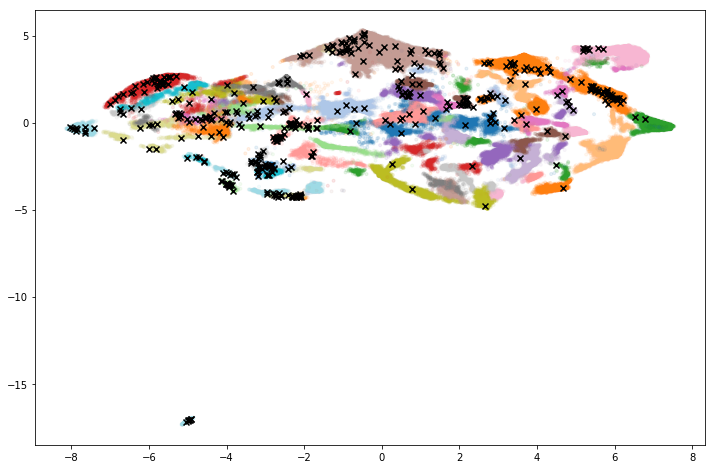

In [24]:
plt.figure(figsize=(12,8))
plt.scatter(umap_kw[clusters_kw>-1,0], umap_kw[clusters_kw>-1,1], 
            c=clusters_kw[clusters_kw>-1], cmap='tab20',alpha=0.1,marker='.')

#plt.scatter(umap_ffs[clusters_ffs==-1,0], umap_ffs[clusters_ffs==-1,1], 
#            c='r', cmap='tab20',alpha=0.5,marker='x')

plt.scatter(umap_ffs[clusters_ffs>-1,0], umap_ffs[clusters_ffs>-1,1], 
            c='k', cmap='tab20',alpha=1,marker='x')


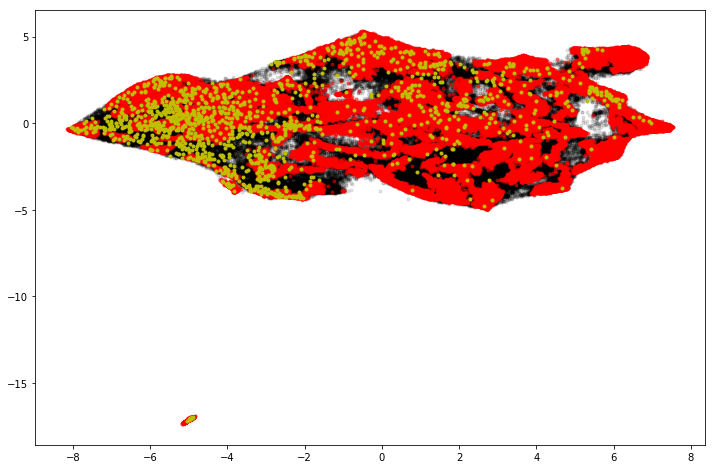

In [16]:
plt.figure(figsize=(12,8))
plt.scatter(umap_kw[clusters_kw==-1,0], umap_kw[clusters_kw==-1,1], 
            c='k', cmap='tab20',alpha=0.1,marker='.')

plt.scatter(umap_kw[clusters_kw>-1,0], umap_kw[clusters_kw>-1,1], 
            c='r', cmap='tab20',alpha=0.5,marker='.')

#plt.scatter(umap_cited[:,0], umap_cited[:,1], 
#            c='b', cmap='tab20',alpha=0.5,marker='.')

plt.scatter(umap_ffs[:,0], umap_ffs[:,1], 
            c='y', cmap='tab20',alpha=1.0,marker='.')


72    -0.042493
83    -0.032922
19    -0.029914
27    -0.028062
48    -0.026701
9     -0.025443
61    -0.016067
57    -0.014264
18    -0.014046
51    -0.013932
101   -0.013037
4     -0.012083
102   -0.009416
2     -0.009267
37    -0.007993
22    -0.007301
90    -0.007058
85    -0.006595
65    -0.006528
24    -0.006460
66    -0.006250
98    -0.005454
76    -0.004968
35    -0.004600
73    -0.004512
38    -0.004298
23    -0.003989
88    -0.003905
100   -0.003602
30    -0.003570
         ...   
124    0.002895
69     0.003181
118    0.003196
125    0.003296
104    0.004177
99     0.004216
33     0.004400
1      0.004748
54     0.004922
113    0.005247
16     0.005352
114    0.006544
107    0.007461
74     0.007890
68     0.008867
14     0.009522
117    0.009598
10     0.011051
12     0.011119
36     0.011861
120    0.012211
121    0.013272
95     0.021585
46     0.026857
6      0.027204
34     0.027852
45     0.033749
77     0.036025
40     0.039502
110    0.053588
Length: 126, dtype: floa

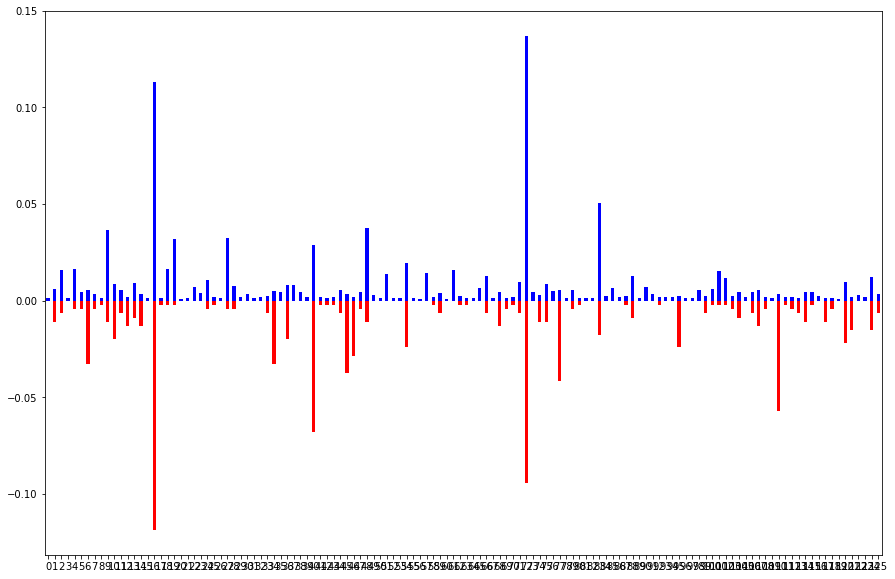

In [47]:
df_incluster = pd.DataFrame({'kw':clusters_kw[clusters_kw>-1].value_counts(sort=False,normalize=True),
                             'ffs':clusters_ffs[clusters_ffs>-1].value_counts(sort=False,normalize=True)})

df_incluster['ffs'].fillna(0,inplace=True)

plt.figure(figsize=(15,10))
df_incluster['kw'].plot.bar(color='b',rot=0)
(-df_incluster['ffs']).plot.bar(color='r',rot=0)

(df_incluster['ffs']-df_incluster['kw']).sort_values()

In [49]:
with pd.option_context('display.max_colwidth', -1):
    display(ffs_abstracts[clusters_ffs==40])

pmid
29114841    cromakalim prodrug cklp water soluble atp sensitive potassium channel opener shown ocular hypotensive property ex vivo vivo experimental model determine mechanism action assessed effect cklp aqueous humor dynamic combination therapy existing ocular hypotensive agent outflow facility assessed bl mouse ex vivo eye perfusion vivo constant flow infusion following cklp treatment human anterior segment trabecular meshwork evaluated effect pressure following cklp treatment cklp alone combination latanoprost timolol rho kinase inhibitor evaluated effect intraocular pressure bl mouse dutch belted pigmented rabbit cklp lowered episcleral venous pressure control mm hg versus treated mm hg detectable effect outflow facility aqueous humor flow rate uveoscleral outflow treatment cklp human anterior segment without trabecular meshwork resulted decrease pressure suggesting effect distal portion conventional outflow pathway cklp worked additively latanoprost timolol lower iop presumabl

In [18]:
with pd.option_context('display.max_colwidth', -1):
    display(kw_abstracts[clusters_kw==16])

pmid
30127501    glaucoma specialist often overlook outer retinal change glaucomatous optic neuropathy typically involves retinal nerve fiber layer rnfl detailed inspection outer retina myopic eye observed separation inner nuclear layer inl outer nuclear layer onl peripapillary sclera pp sclera therefore conducted retrospective observation eye korean subject myopia assessed swept source optical coherence tomography ssoct divided normal glaucomatous eye mean subject age refractive error axial length difference group insignificant respectively quantify onl inl separation straight line distance onl endpoint inl endpoint measured center optic disc ssoct horizontal scan glaucomatous group significantly large onl inl separation non glaucomatous group significant difference inl anterior scleral canal opening asco separation width onl inl separation associated peripapillary atrophy ppa degree horizontal tilt optic disc worse glaucomatous rnfl defect pearson correlation analysis respectively co

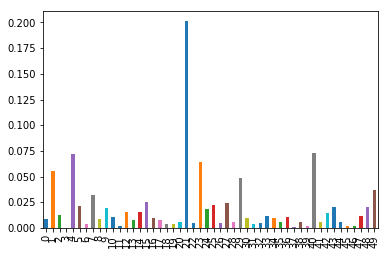

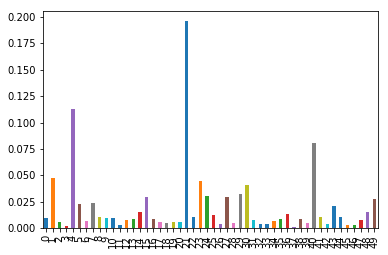

In [19]:
lda_ffs[clusters_ffs==16].mean().plot.bar()

plt.figure()
lda_kw[clusters_kw==16].mean().plot.bar()

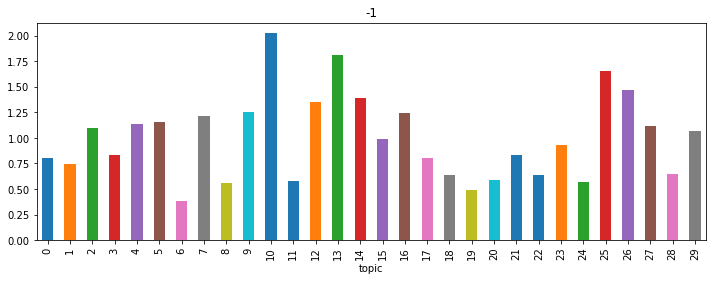

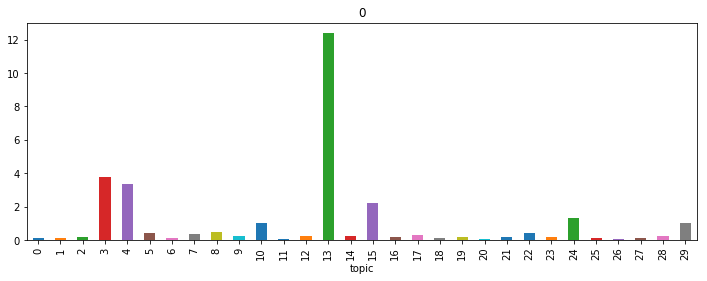

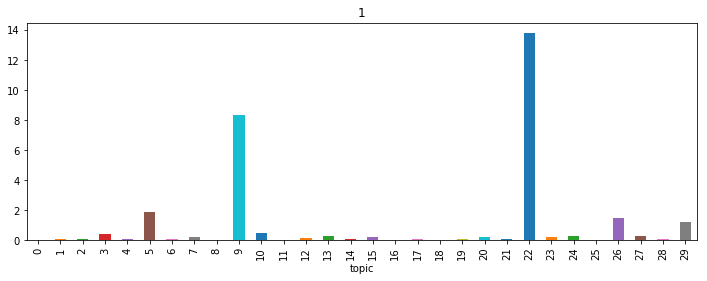

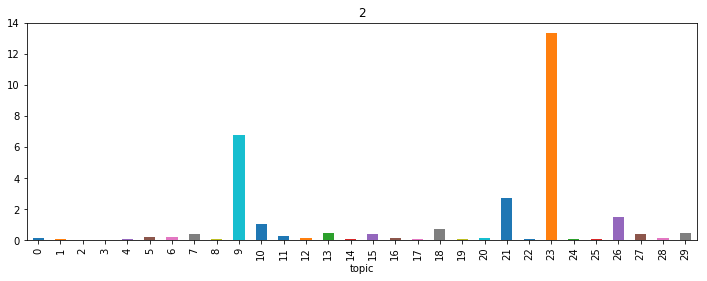

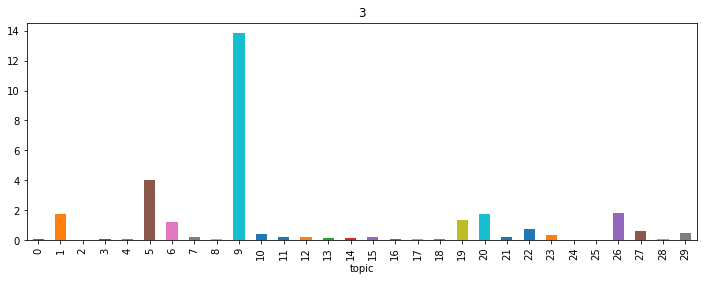

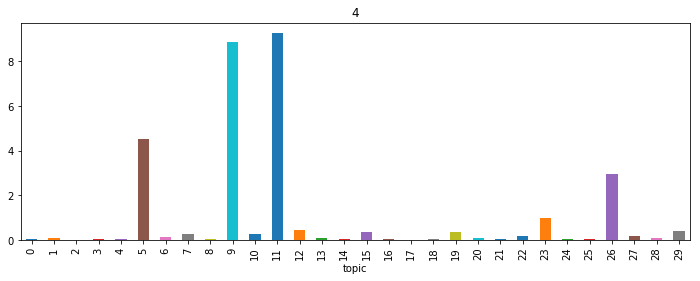

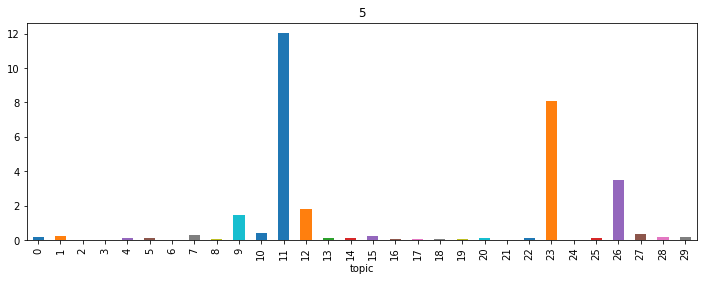

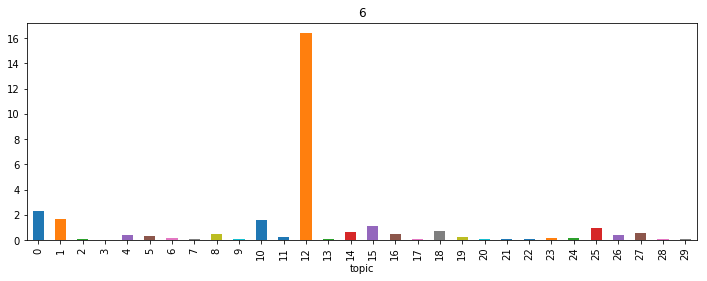

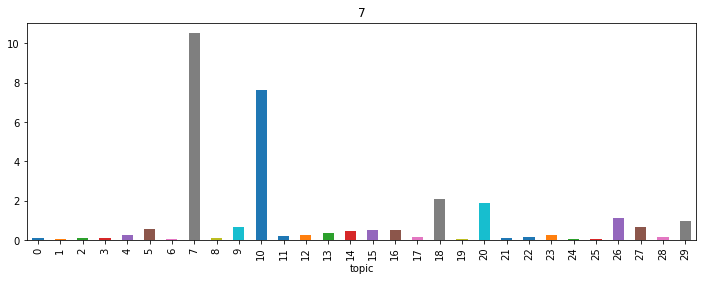

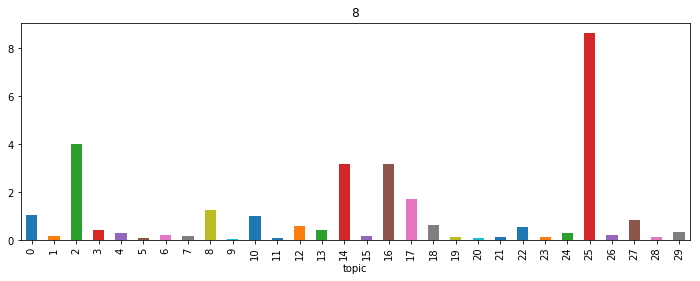

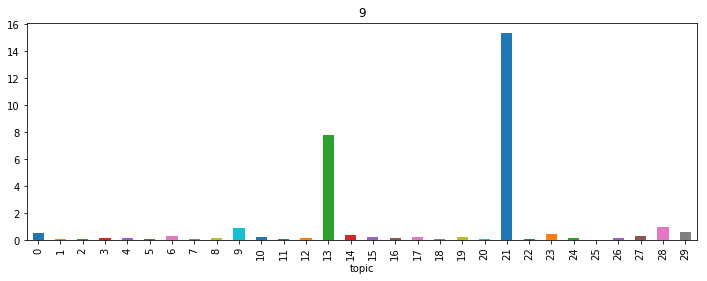

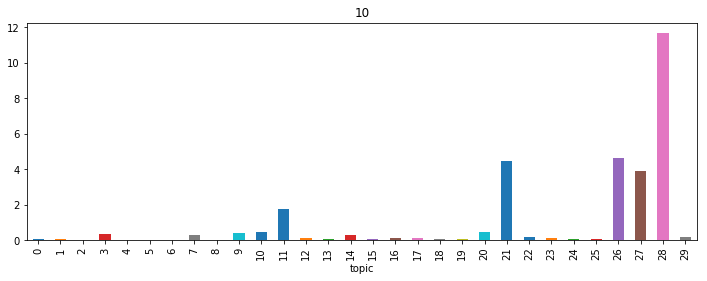

In [143]:
cluster_mean_topic = lda_kw.groupby(clusters_kw).mean()
for i,row in cluster_mean_topic.iterrows():#.columns:
    plt.figure(figsize=(12,4))
    #cluster_mean_topic[col].plot.bar()
    (30*row).plot.bar()
    plt.title(i)
    plt.xlabel('topic')

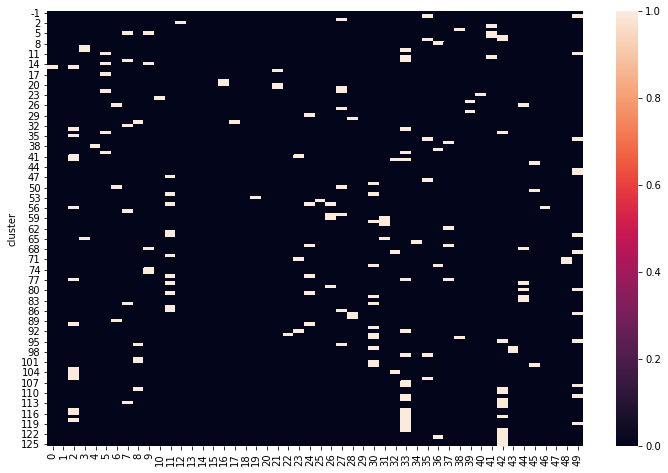

In [22]:
cluster_mean_topic = lda_kw.groupby(clusters_kw).mean()

plt.figure(figsize=(12,8))
sns.heatmap(cluster_mean_topic>0.15)

In [84]:
(lda_ffs>0.2).sum(axis=1).sort_values(ascending=False)
lda_ffs.loc['17360570'].sort_values(ascending=False)

2     0.296469
0     0.232394
17    0.201244
16    0.116121
14    0.058522
25    0.025661
19    0.024981
5     0.023307
21    0.016602
28    0.000224
15    0.000224
10    0.000224
12    0.000224
23    0.000224
27    0.000224
4     0.000224
29    0.000224
13    0.000224
9     0.000224
8     0.000224
6     0.000224
3     0.000224
22    0.000224
11    0.000224
1     0.000224
7     0.000224
18    0.000224
26    0.000224
20    0.000224
24    0.000224
Name: 17360570, dtype: float64

In [99]:
countvec = joblib.load('models/sklearn/CountVec.joblib')
count_ffs = countvec.transform(ffs_abstracts)
count_ffs = pd.DataFrame(count_ffs.toarray(),columns=features,index=ffs_pmids)

In [130]:
count_ffs
papercounts = count_ffs.loc['17360570']

wordtopics = topics[papercounts[papercounts>0].index].idxmax(axis=0).sort_values()

print(wordtopics[wordtopics==2].index.values)
print('-----------')
print(wordtopics[wordtopics==0].index.values)
print('-----------')
print(wordtopics[wordtopics==17].index.values)
print('-----------')
print(wordtopics[wordtopics==16].index.values)


['rab' 'rescued' 'trafficking' 'nonsense mutation' 'nonsense' 'mutant'
 'linked' 'hereditary' 'gene' 'recessive' 'mutation' 'zebrafish'
 'characterized' 'choroideremia' 'cause' 'analysis revealed' 'carry'
 'defect']
-----------
['photoreceptor outer' 'membrane' 'wild type' 'outer segment'
 'epithelium rpe' 'pigment' 'pigment epithelium' 'epithelium'
 'retinal pigment' 'rpe' 'transport' 'wild']
-----------
['retinal degeneration' 'opsin' 'photoreceptors' 'photoreceptor loss'
 'photoreceptor death' 'photoreceptor' 'complete loss' 'mosaic'
 'hereditary retinal' 'degenerated' 'function measured'
 'electroretinogram' 'potential']
-----------
['cellular process' 'posttranslational' 'potential treatment' 'process'
 'involved' 'regulate' 'pathology' 'function' 'critical' 'cellular'
 'degeneration']


In [131]:
ffs_abstracts.loc['17360570']

'choroideremia linked hereditary retinal degeneration resulting mutation rab escort protein rep rep protein facilitates posttranslational modification rab protein regulate intracellular trafficking retinal pigment epithelium rpe photoreceptors likely involved removal outer segment disk membrane rpe critical question potential treatment choroideremia whether photoreceptor degeneration result autonomous defect opsin transport within photoreceptor nonautonomous secondary consequence rpe degeneration address question characterized retinal pathology zebrafish rep mutant carry recessive nonsense mutation rep gene zebrafish rep mutant exhibit degeneration rpe photoreceptors complete loss visual function measured electroretinogram mutant rpe photoreceptor outer segment material effectively eliminated large vacuole observed however opsin trafficking photoreceptors occurred normally mosaic analysis revealed photoreceptor degeneration nonautonomous required contact mutant rpe mutant photoreceptor

In [89]:
#abswords = set(ffs_abstracts.loc['17360570'].split())
#wordtopics = {}
#for word in abswords:
#    if topics.columns.contains(word):
#        wordtopics[word] = topics[word].idxmax()

#wordtopics = pd.Series(wordtopics)
#wordtopics[wordtopics.isin([2,0,17,16])].sort_values()


In [57]:
topics.loc[17].sort_values(ascending=False)

disorder                14888.677922
renal                   14862.359020
role                    11922.010707
virus                   11081.890108
mitochondrial            7995.120083
cause                    7488.267873
play                     6617.933863
hsv                      6457.772377
environmental            5994.047351
dysfunction              5946.652393
retinitis                5844.550455
type                     5494.574358
viral                    5395.633358
subunit                  4489.173796
decade                   4345.809317
complex                  4194.105976
hereditary               4014.498765
genetic                  3933.792180
pathogenesis             3841.801319
important                3784.078058
form                     3677.602327
pigmentosa               3677.241361
retinitis pigmentosa     3633.321714
common                   3608.310214
herpes                   3567.365934
syndrome                 3381.397499
bb                       3361.905381
p

In [54]:
with pd.option_context('display.max_colwidth', -1):
    display(ffs_abstracts[lda_ffs.idxmax(axis=1)==12])


pmid
28821263    currently per child industrialised world severely visually impaired blind svi bl due diverse uncommon condition usually present early infancy impact svi bl lifelong life changing thus child priority led global initiative avoidable blindness aim scoping review ass current evidence base intervention prevent treat major cause childhood svi bl specifically degree alignment robust interventional research rcts burden relative frequency key causative disorder identifying gap evidence base tackling childhood blindness perform scoping review published literature randomised controlled trial rcts clinical intervention prevent treat eye vision disease child year old major electronic database medline pubmed embase cochrane central searched identify published trial using comprehensive paediatric specific strategy informed previous search outcome study randomised clinical trial activity measured total number rcts total paediatric participant randomised quantity distribution activity 